<a href="https://colab.research.google.com/github/ThesplumCoder/formula1-ia-model/blob/main/ProyectoIA_Formula_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

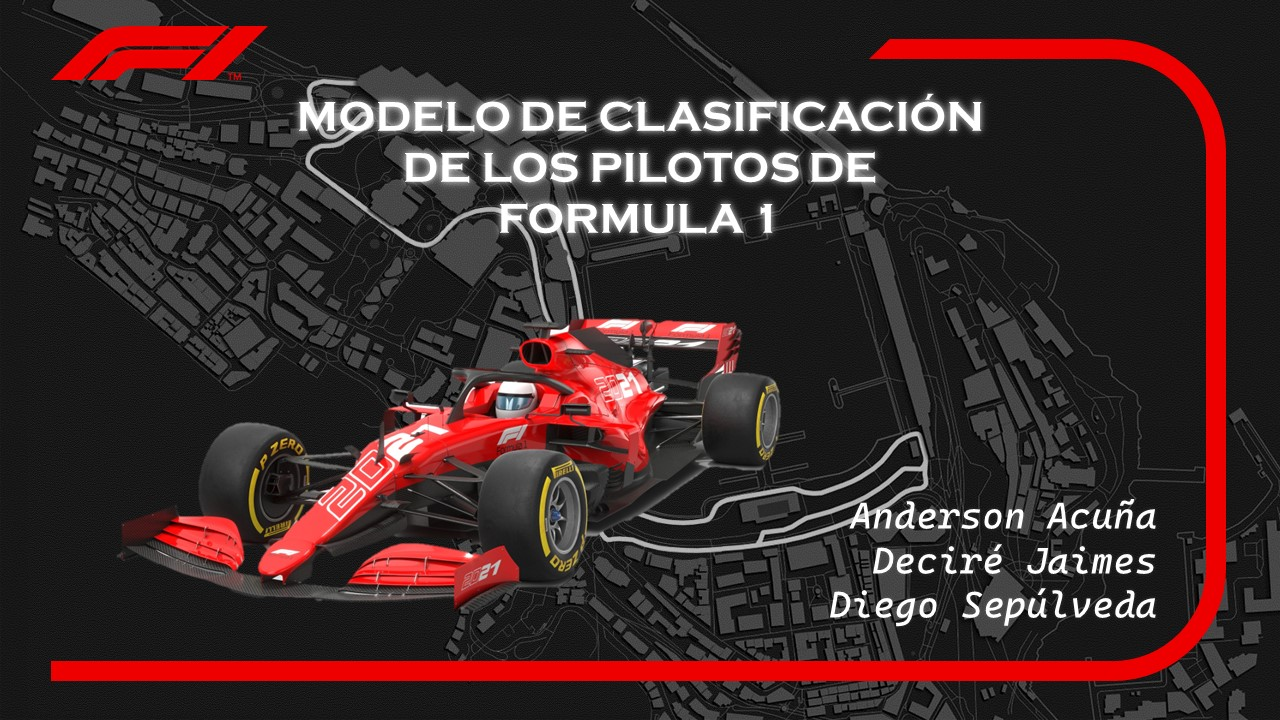

# Proyecto IA - Formula 1

**Contenido**
1. [Configuración del Entorno](#title1)
2. [Construcción del Conjunto de Datos](#title2)
3. [Prueba de Diferentes Clasificadores](#title3)
4. [Gráficas de Resultados y Elección de el Regresor]()
5. [Personalización de Parámetros]()

## Configuración del Entorno<a name="title1"></a>

Importamos todas las librerías de uso.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats

sns.set_theme()

Importamos los archivos del drive.

In [ ]:
import os
from google.colab import drive

path_ai = "PROYECTO_AI"
path = "/content/drive/My Drive/" + path_ai
drive.mount('/content/drive')
os.chdir(path)
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/PROYECTO_AI


## Construcción del Conjunto de Datos<a name="title2"></a>

Fuente: https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020/data & https://www.kaggle.com/datasets/cjgdev/formula-1-race-data-19502017

Importamos los archivos con los datos codificados en identificadores. El archivo principal es el de `results.csv`. Los otros archivos mapean datos específicos que podrían reemplazarse en el archivo principal.

In [ ]:
results = pd.read_csv('formula1/results.csv')
drivers = pd.read_csv('data/drivers.csv')
circuits = pd.read_csv('data/circuits.csv')
status = pd.read_csv('data/status.csv')
pits = pd.read_csv('formula1/pitStops.csv')

Seleccionamos las columnas que vamos a utilizar:

In [ ]:
target_columns = ['resultId', 'raceId', 'driverId',
                  'constructorId', 'grid',
                  'positionOrder', 'points', 'laps',
                  'milliseconds', 'fastestLap','fastestLapSpeed',
                  'statusId']

results = results.loc[:, target_columns]
results['lapPit'] = pits['lap']

Vista de `results.csv`.

In [ ]:
results.head()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,laps,milliseconds,fastestLap,fastestLapSpeed,statusId,lapPit
0,1,18,1,1,1,1,10.0,58,5690616.0,39.0,218.3,1,1.0
1,2,18,2,2,5,2,8.0,58,5696094.0,41.0,217.586,1,1.0
2,3,18,3,3,7,3,6.0,58,5698779.0,41.0,216.719,1,11.0
3,4,18,4,4,11,4,5.0,58,5707797.0,58.0,215.464,1,12.0
4,5,18,5,1,3,5,4.0,58,5708630.0,43.0,218.385,1,13.0


In [ ]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23777 entries, 0 to 23776
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         23777 non-null  int64  
 1   raceId           23777 non-null  int64  
 2   driverId         23777 non-null  int64  
 3   constructorId    23777 non-null  int64  
 4   grid             23777 non-null  int64  
 5   positionOrder    23777 non-null  int64  
 6   points           23777 non-null  float64
 7   laps             23777 non-null  int64  
 8   milliseconds     6003 non-null   float64
 9   fastestLap       5383 non-null   float64
 10  fastestLapSpeed  5383 non-null   object 
 11  statusId         23777 non-null  int64  
 12  lapPit           6251 non-null   float64
dtypes: float64(4), int64(8), object(1)
memory usage: 2.4+ MB


In [ ]:
results.describe()

,resultId,raceId,driverId,constructorId,grid,positionOrder,points,laps,milliseconds,fastestLap,statusId,lapPit
count,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,23777.000000,6.003000e+03,5383.000000,23777.000000,6251.000000
mean,11889.481053,487.203937,226.515961,46.281785,11.270303,13.081591,1.601403,45.270598,6.303313e+06,41.061676,18.242293,24.813470
std,6864.691322,269.904857,231.386102,56.174091,7.346436,7.824711,3.665154,30.525404,1.721748e+06,17.156435,26.380824,14.150022
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.474899e+06,2.000000,1.000000,1.000000
25%,5945.000000,273.000000,55.000000,6.000000,5.000000,7.000000,0.000000,20.000000,5.442948e+06,29.000000,1.000000,13.000000
50%,11889.000000,478.000000,154.000000,25.000000,11.000000,13.000000,0.000000,52.000000,5.859428e+06,44.000000,11.000000,24.000000
75%,17833.000000,718.000000,314.000000,57.000000,17.000000,19.000000,1.000000,66.000000,6.495440e+06,53.000000,16.000000,35.000000
max,23781.000000,988.000000,843.000000,210.000000,34.000000,39.000000,50.000000,200.000000,1.509054e+07,78.000000,136.000000,74.000000


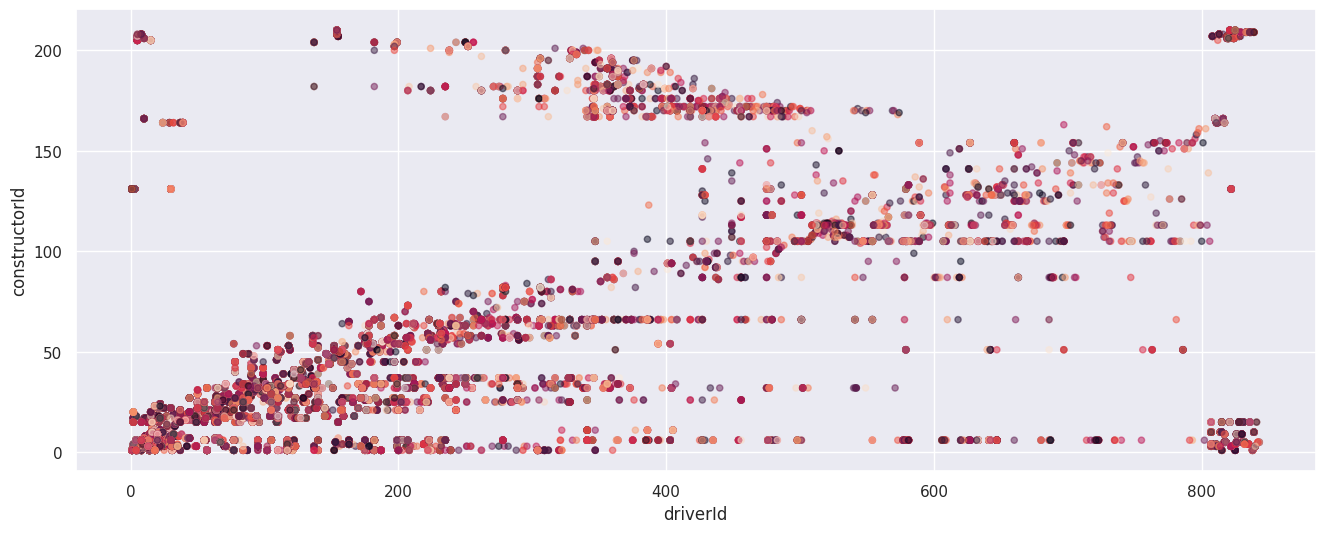

In [ ]:
colors = np.random.rand(results.shape[0])
results.plot(kind = 'scatter', x = 'driverId', y = 'constructorId', c = colors, figsize=(16,6), alpha = 0.5)
plt.show()

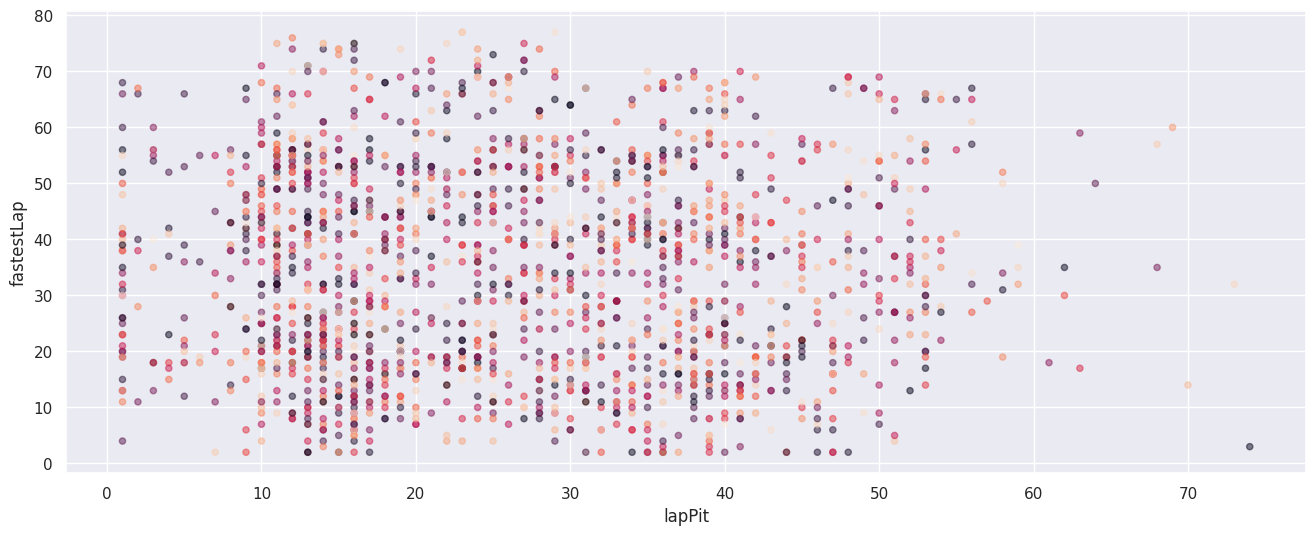

In [ ]:
results.plot(kind = 'scatter', x = 'lapPit', y = 'fastestLap', c = colors, figsize=(16,6), alpha = 0.5)
plt.show()

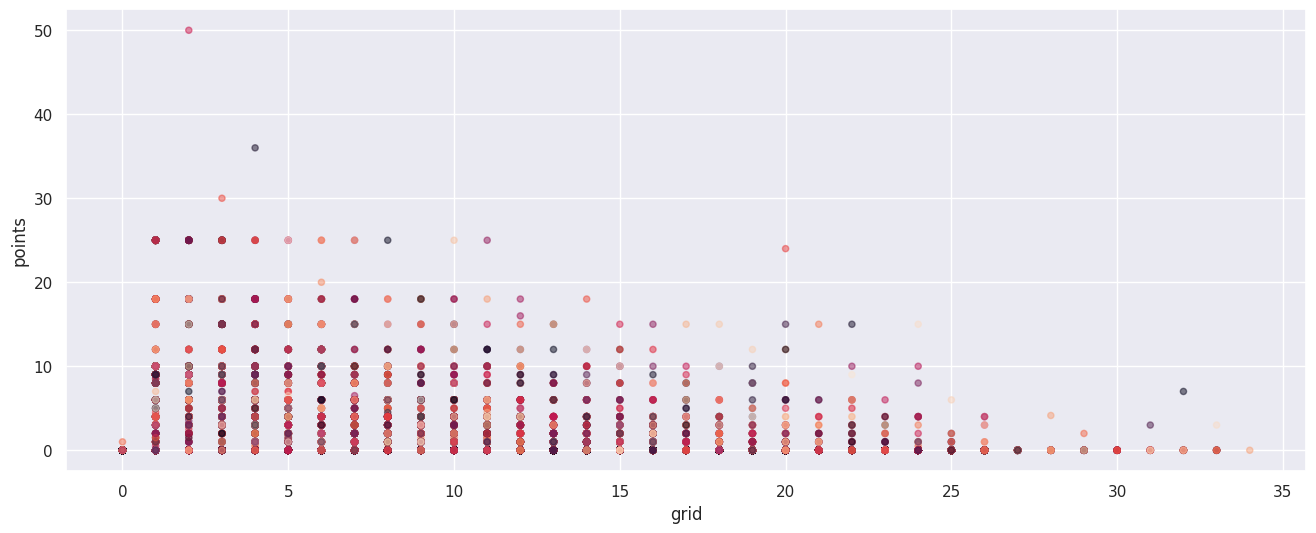

In [ ]:
results.plot(kind = 'scatter', x = 'grid', y = 'points', c = colors, figsize=(16,6), alpha = 0.5)
plt.show()

Limpiamos los datos y convertimos las columnas a tipo numérico:

In [ ]:
results['milliseconds'] = results['milliseconds'].fillna(value = 1.510000e+07)
results['fastestLapSpeed'] = results['fastestLapSpeed'].replace(to_replace = "01:42.6", value = "194.86")
results['fastestLap'] = results['fastestLap'].fillna(0)
results['fastestLapSpeed'] = results['fastestLapSpeed'].fillna(257.32)
results['lapPit'] = results['lapPit'].fillna(np.random.randint(results['lapPit'].mean().round(0)))

results['fastestLapSpeed'] = pd.to_numeric(results['fastestLapSpeed'])
results['lapPit'] = pd.to_numeric(results['lapPit'])

<Axes: >

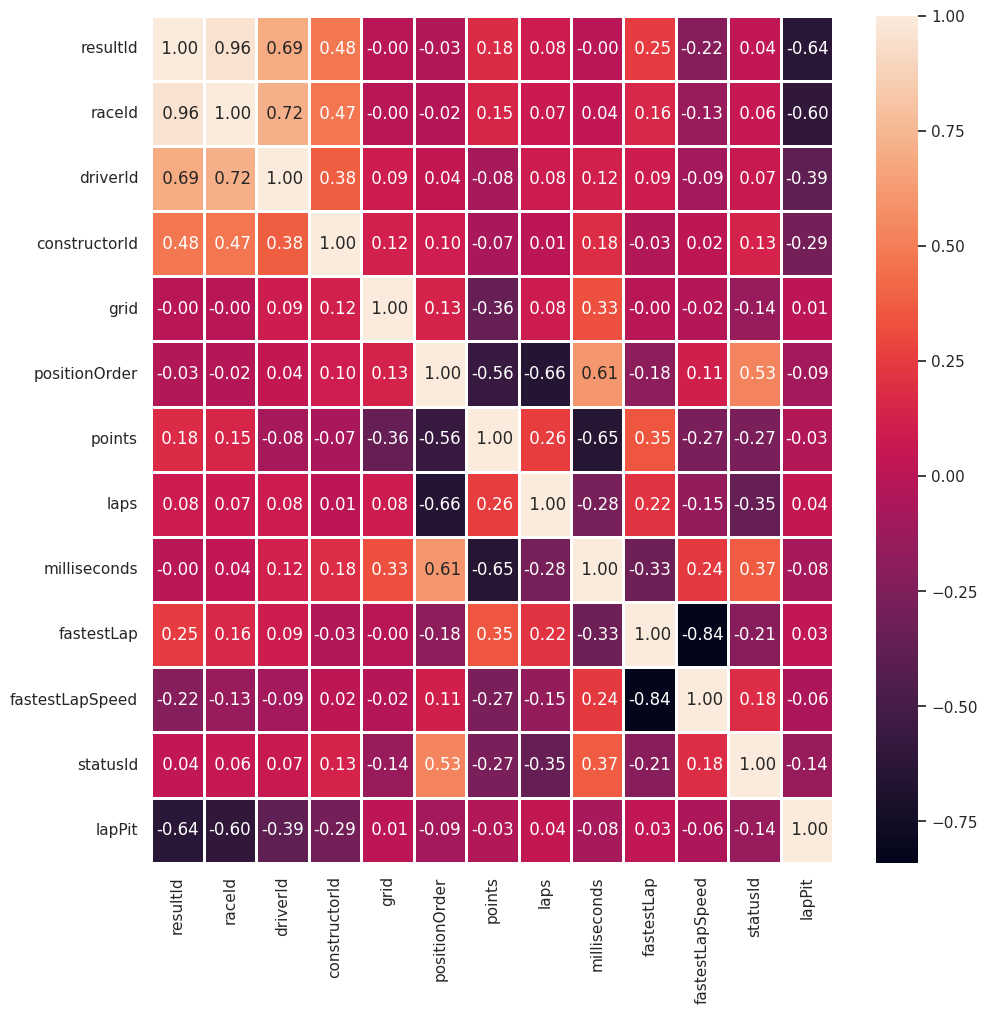

In [ ]:
corr = results.corr()
plt.figure(figsize=(11,11))
sns.heatmap(corr, annot=True, fmt=" .2f", linewidths=1)

# Prueba de Diferentes Clasificadores<a name="title3"></a>

Fijamos como *ground truth* la columna de `positionOrder`, ya que, el objetivo de nuestro modelo será predecir la posición final del corredor según los otros datos de insumo.

In [ ]:
from sklearn.model_selection import train_test_split

ground_truth = 'positionOrder'
X = results.loc[:, results.columns != ground_truth]
y = results.loc[:, ground_truth]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

> No utilizamos `.values` porque se corre el riesgo de un casteo ascendente que convertiría nuestras columnas de tipo `int` a tipo `float`.

Iniciando en cada clasificador con el tunning para luego pasar a la predicción y su respectivo accuracy

## Árbol de Decisión o `DecisionTreeClassifier`

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.tree import DecisionTreeClassifier


def show_curve_dt(est, parameter_name, values):
  means, stds = [], []
  if est == 'dt':
    if parameter_name == 'max_depth':
      for param_value in values:
        dt = DecisionTreeClassifier(max_depth = param_value)
        s = cross_val_score(dt, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
        means.append(np.mean(s))
        stds.append(np.std(s))
    if parameter_name == 'criterion':
      for param_value in values:
        dt = DecisionTreeClassifier(criterion = param_value)
        s = cross_val_score(dt, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
        means.append(np.mean(s))
        stds.append(np.std(s))

  means = np.r_[means]
  stds  = np.r_[stds]

  plt.plot(values, means, label="mean", color="black")
  plt.fill_between(values, means-stds, means+stds, color="blue", alpha=.5, label="std")
  plt.xlabel(parameter_name)
  plt.ylabel("performance")
  plt.legend()

Se muestran las gráficas para el mejor max_depth y el mejor criterion

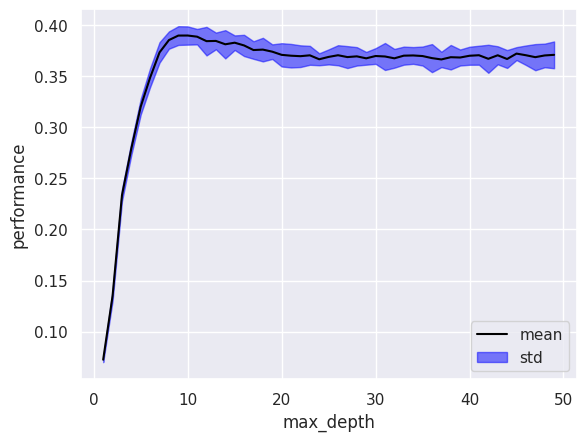

In [ ]:
show_curve_dt('dt', 'max_depth', range(1, 50))

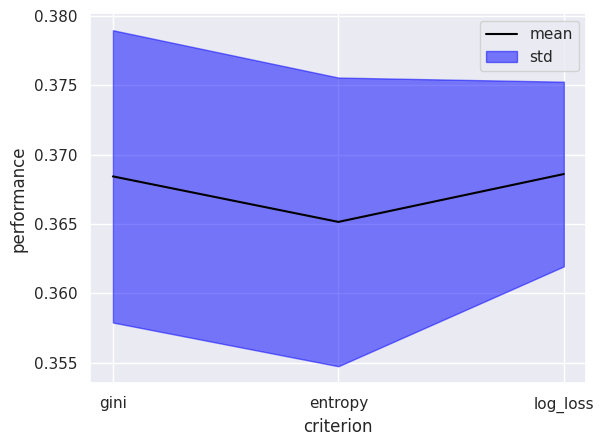

In [ ]:
show_curve_dt('dt', 'criterion', ['gini', 'entropy', 'log_loss'])

Realizando la clasificación con los datos obtenidos durante el tunning

In [ ]:
from sklearn.tree import DecisionTreeClassifier

est = DecisionTreeClassifier(max_depth=9, criterion='gini')
est.fit(X_train,y_train)
accuracy_DT = accuracy_score(est.predict(X_test), y_test)
print(accuracy_DT)

0.38758059994393046


## Bosque Aleatorío o `RandomForestClassifier`

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.ensemble import RandomForestClassifier


def show_curve_rf(est, parameter_name, values):
  means, stds = [], []
  if est == 'rf':
    if parameter_name == 'max_depth':
      for param_value in values:
        rf = RandomForestClassifier(max_depth = param_value)
        s = cross_val_score(rf, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
        means.append(np.mean(s))
        stds.append(np.std(s))
    if parameter_name == 'criterion':
      for param_value in values:
        rf = RandomForestClassifier(criterion = param_value)
        s = cross_val_score(rf, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
        means.append(np.mean(s))
        stds.append(np.std(s))
    if parameter_name == 'n_estimators':
      for param_value in values:
        rf = RandomForestClassifier(n_estimators = param_value)
        s = cross_val_score(rf, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
        means.append(np.mean(s))
        stds.append(np.std(s))

  means = np.r_[means]
  stds  = np.r_[stds]

  plt.plot(values, means, label="mean", color="black")
  plt.fill_between(values, means-stds, means+stds, color="blue", alpha=.5, label="std")
  plt.xlabel(parameter_name)
  plt.ylabel("performance")
  plt.legend()

Se muestran las gráficas para el mejor max_depth y el mejor criterion

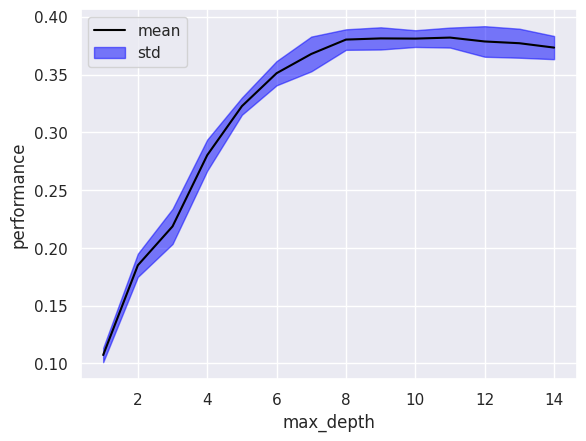

In [ ]:
show_curve_rf('rf', 'max_depth', range(1, 15))

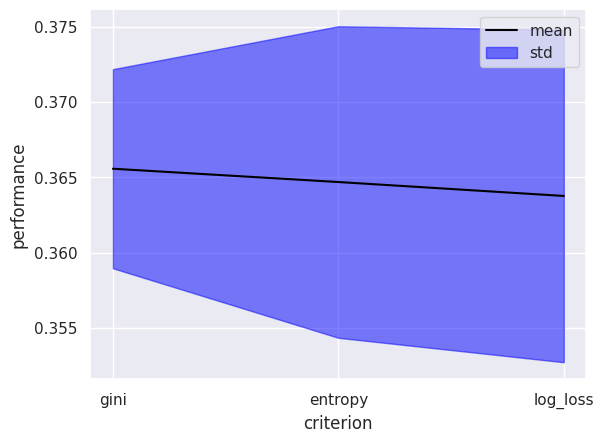

In [ ]:
show_curve_rf('rf', 'criterion', ['gini', 'entropy', 'log_loss'])

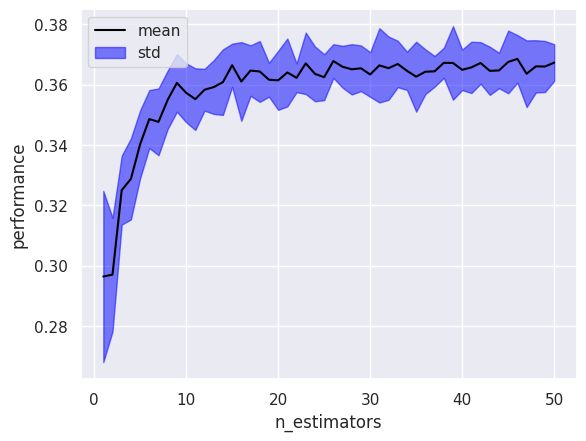

In [ ]:
show_curve_rf('rf', 'n_estimators', range(1, 51))

Realizando la clasificación con los datos obtenidos durante el tunning

In [ ]:
from sklearn.ensemble import RandomForestClassifier

est = RandomForestClassifier(n_estimators=46, max_depth=9, criterion='gini')
est.fit(X_train,y_train)
accuracy_RF = accuracy_score(est.predict(X_test), y_test)
print(accuracy_RF)

0.37706756377908607


## Maquina de soporte vectorial o `SVC`

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.svm import SVC


def show_curve_svc(est, parameter_name, values, poly_degres = 2):
  means, stds = [], []
  if est == 'svc':
    if parameter_name == 'kernel':
      for param_value in values:
        estSvc = SVC(kernel = param_value)
        s = cross_val_score(estSvc, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
        means.append(np.mean(s))
        stds.append(np.std(s))
    if parameter_name == 'C':
      for param_value in values:
        estSvc = SVC(C = param_value)
        s = cross_val_score(estSvc, X, y, cv=KFold(10, shuffle=True), scoring=make_scorer(accuracy_score))
        means.append(np.mean(s))
        stds.append(np.std(s))

  means = np.r_[means]
  stds  = np.r_[stds]

  plt.plot(values, means, label="mean", color="black")
  plt.fill_between(values, means-stds, means+stds, color="blue", alpha=.5, label="std")
  plt.xlabel(parameter_name)
  plt.ylabel("performance")
  plt.legend()

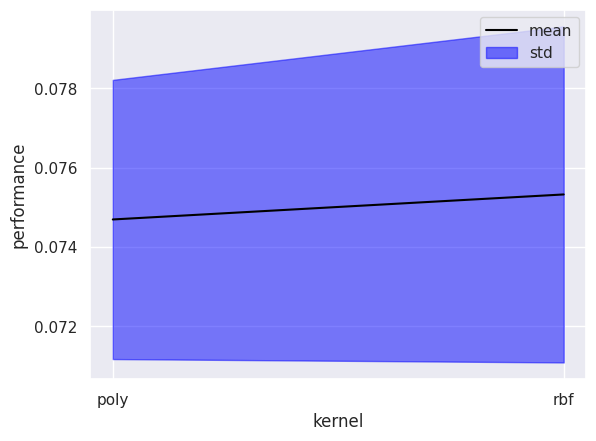

In [ ]:
show_curve_svc('svc', 'kernel', ['poly', 'rbf'])

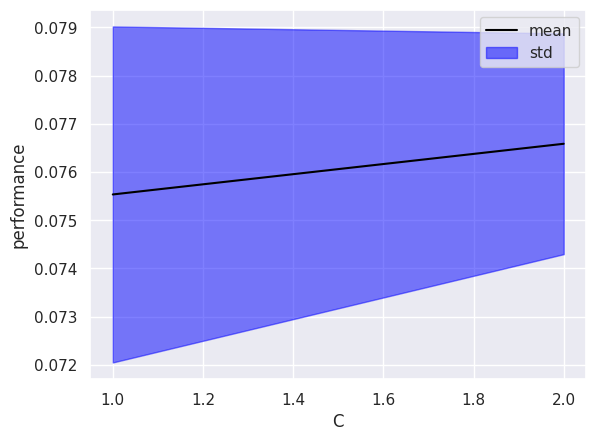

In [ ]:
c_values = [float(c) for c in range(1, 3)]

show_curve_svc('svc', 'C', c_values)

In [ ]:
from sklearn.svm import SVC

est = SVC(C=2.0, kernel='rbf')
est.fit(X_train,y_train)
accuracy_SVC = accuracy_score(est.predict(X_test), y_test)
print(accuracy_SVC)

0.07415194841603588


##COMPARANDO LOS 3 METODOS DE CLASIFICACION

['accuracy_DT', 'accuracy_RF', 'accuracy_SVC']


<BarContainer object of 3 artists>

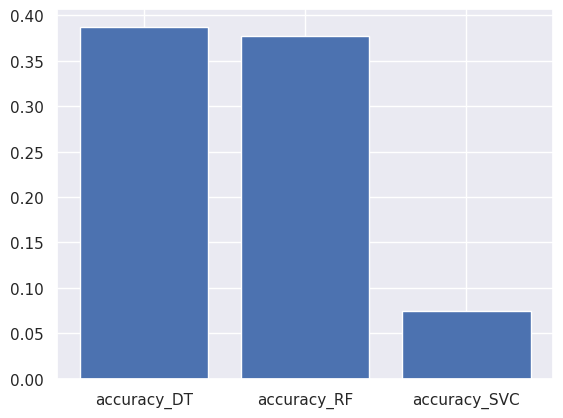

In [ ]:
x = ["accuracy_DT","accuracy_RF", "accuracy_SVC"]
y = [accuracy_DT,accuracy_RF, accuracy_SVC]
print(x)
fig, ax = plt.subplots()
ax.bar(x,y)

El mejor método de clasificación fue el DecisionTree